In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStam

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    time.sleep(0.5)

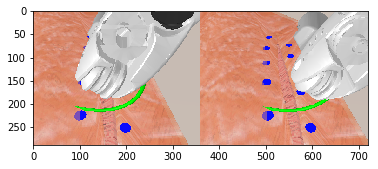

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM2_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM1',
 'PSM2',
 'PSM3',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ecm_yaw_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM1_tool_wrist_sca_ee_link_0',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM2_outer_pitch_link',
 'PSM1_tool_tip_link',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM1_outer_pitch_top_link',
 'PSM2_tool_wrist_caudier_link',
 'PSM1_outer_yaw_link',
 'ecm_roll_link',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM2_outer_pitch_back_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'simcamera',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM1_outer_insertion_link',
 'PSM2_outer_pitch_bottom_link',
 'ecm_insertion_link',
 'PSM1_outer_pitch_bottom_link',
 'PSM2_tool_wrist_c

In [6]:
tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time())

([0.656836765181166, 0.8182954030101346, 1.40013498232118],
 [-0.579343318939209,
  0.4056306779384613,
  -0.40548548102378845,
  -0.5791429877281189])

In [7]:
psm1 = dvrk.psm('PSM1')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [8]:
ECM_STARTING_JOINT_POS = np.asarray([-0.17487798,  0.24544429,  0.08878391,  0.21899393])
ecm.move_joint(ECM_STARTING_JOINT_POS)

True

In [9]:
tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))

In [51]:
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)

True

[-0.00236842 -0.01394737  0.04104741]
[ -0.00236842,  -0.0139474,   0.0410474]
[ 0.00916667 -0.00952381  0.03713814]
[  0.00916667, -0.00952381,   0.0371381]
[-0.00064516 -0.00467742  0.05031619]
[-0.000645161, -0.00467742,   0.0503162]
[ 0.01042857 -0.00114286  0.04456576]
[   0.0104286, -0.00114286,   0.0445658]
[0.00055556 0.00333333 0.05777044]
[ 0.000555556,  0.00333333,   0.0577704]
[0.01547619 0.00833333 0.07427627]
[   0.0154762,  0.00833333,   0.0742763]
[0.00229167 0.01020833 0.06499174]
[  0.00229167,   0.0102083,   0.0649917]
[0.0126     0.0132     0.06239207]
[      0.0126,      0.0132,   0.0623921]
[0.00295455 0.01659091 0.07090008]
[  0.00295455,   0.0165909,   0.0709001]
[0.011875   0.01875    0.06499174]
[    0.011875,     0.01875,   0.0649917]


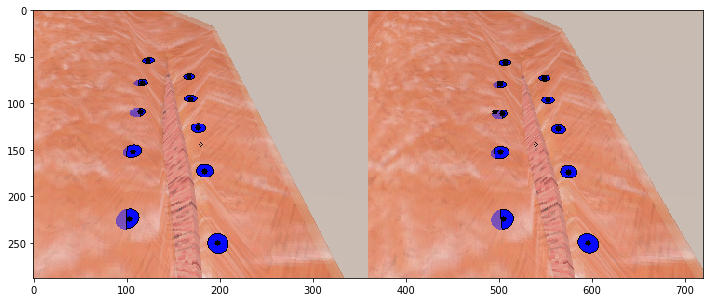

In [11]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)
objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)

In [12]:
objects

[[    -1.50041,  -0.0241301,    0.695999],
 [    -1.49695,  -0.0131349,     0.70192],
 [    -1.48734,  -0.0260987,    0.696182],
 [    -1.48587,  -0.0150119,    0.702749],
 [     -1.4765,  -0.0279678,    0.696727],
 [    -1.45765,   -0.017848,     0.68883],
 [    -1.46644,  -0.0290559,    0.696622],
 [    -1.46338,  -0.0192191,      0.7006],
 [    -1.45791,  -0.0308213,    0.697077],
 [    -1.45807,  -0.0215056,    0.702763]]

In [13]:
ecm.get_current_joint_position()

array([-0.17487799,  0.24544428,  0.08878391,  0.21899393])

In [14]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
for pt in objects:
    objects.remove(pt)
    pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    paired_pts.append(
        (min(pt, pt2, key=lambda p: p.y()), max(pt, pt2, key=lambda p: p.y())))
paired_pts

[([    -1.50041,  -0.0241301,    0.695999],
  [    -1.49695,  -0.0131349,     0.70192]),
 ([    -1.48734,  -0.0260987,    0.696182],
  [    -1.48587,  -0.0150119,    0.702749]),
 ([     -1.4765,  -0.0279678,    0.696727],
  [    -1.48587,  -0.0150119,    0.702749]),
 ([    -1.46644,  -0.0290559,    0.696622],
  [    -1.46338,  -0.0192191,      0.7006]),
 ([    -1.45791,  -0.0308213,    0.697077],
  [    -1.45807,  -0.0215056,    0.702763])]

In [52]:
# calculate a desired pose
# this is really pushing my first year linear algebra skills
# we want the insertion to go from the min y point to the max y point
import math


# the desired rotation is calculated by setting the entry-to-exit vector of the suture as the x-axis vector,
# setting x-axis cross (0, 0, 1) as the z-axis vector, and setting the y-axis vector to the x-axis cross z-axis.
def calculate_desired_entry_pose(entry_and_exit_point):
    entry_to_exit_vector = entry_and_exit_point[1] - entry_and_exit_point[0]
    entry_to_exit_vector.Normalize()
    desired_z_vector = entry_to_exit_vector * PyKDL.Vector(0, 0, 1)
    desired_x_vector = entry_to_exit_vector
    desired_y_vector = desired_z_vector * desired_x_vector 
    desired_rotation = \
        PyKDL.Rotation(desired_x_vector, desired_y_vector, desired_z_vector)
    desired_position = entry_and_exit_point[0] + PyKDL.Vector(0, 0, 0.023) \
        - (desired_z_vector * 0.01) - (desired_x_vector * 0.005)
    return PyKDL.Frame(desired_rotation, desired_position)
   
desired_pose = calculate_desired_entry_pose(paired_pts[0])
psm1.move(tf_world_to_psm1 * desired_pose)

True

In [53]:
def calculate_desired_insertion_pose(entry_pose):
    desired_insertion_pos = (entry_pose.M * PyKDL.Vector(-0.007, -0.02, 0)) + entry_pose.p
    # TODO: change this
    desired_insertion_rotation = deepcopy(entry_pose.M)
    desired_insertion_rotation.DoRotZ(np.pi / 2 + 0.2)
    return PyKDL.Frame(desired_insertion_rotation, desired_insertion_pos)

desired_insertion_pose = calculate_desired_insertion_pose(desired_pose)
psm1.move(tf_world_to_psm1 * desired_insertion_pose)

True

In [54]:
def calculate_desired_extraction_pose(insertion_pose):
    new_rotation = deepcopy(insertion_pose.M)
    new_rotation.DoRotZ(np.pi - 0.25)
    return PyKDL.Frame(new_rotation, insertion_pose.p + insertion_pose.M * PyKDL.Vector(-0.006, -0.0205, 0.0005))

desired_extraction_pose = calculate_desired_extraction_pose(desired_insertion_pose)
psm1.open_jaw()
psm1.move(tf_world_to_psm1 * desired_extraction_pose)
psm1.close_jaw()

True

In [55]:
def calculate_desired_completion_pose(extraction_pose):
    desired_completion_pos = (extraction_pose.M * PyKDL.Vector(-0.025, -0.005, 0)) + extraction_pose.p
    desired_completion_rotation = deepcopy(extraction_pose.M)
    desired_completion_rotation.DoRotZ(np.pi / 2 + 0.2)
    return PyKDL.Frame(desired_completion_rotation, desired_completion_pos)

desired_completion_pose = calculate_desired_completion_pose(desired_extraction_pose)
psm1.move(tf_world_to_psm1 * desired_completion_pose)

True

In [56]:
# this can literally be a random pose as long as it's flat
def calculate_desired_drop_pose(entry_and_exit_point):
    entry_to_exit_vector = entry_and_exit_point[1] - entry_and_exit_point[0]
    entry_to_exit_vector.Normalize()
    desired_position = entry_and_exit_point[1] + (entry_to_exit_vector * 0.026)
    desired_orientation = PyKDL.Rotation(0, 1, 0, 1, 0, 0, 0, 0, -1)
    return PyKDL.Frame(desired_orientation, desired_position)

desired_drop_pose = calculate_desired_drop_pose(paired_pts[0])
psm1.move(tf_world_to_psm1 * desired_drop_pose)

True

In [57]:
def calculate_desired_pickup_pose(drop_pose):
    pickup_position = drop_pose.p - (drop_pose.M * PyKDL.Vector(0, 0.02, 0))
    pickup_orientation = deepcopy(drop_pose.M)
    pickup_orientation.DoRotZ(np.pi + 0.25)
    return PyKDL.Frame(pickup_orientation, pickup_position)

desired_pickup_pose = calculate_desired_pickup_pose(desired_drop_pose)
psm1.open_jaw()
psm1.move(tf_world_to_psm1 * desired_pickup_pose)
psm1.close_jaw()

True

In [58]:
desired_pose = calculate_desired_entry_pose(paired_pts[1])
psm1.move(tf_world_to_psm1 * desired_pose)

True

[ERROR] [1598420796.720318]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7eff5456c0d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

